# **CNN RL AGENT VISUALISATION**

Notebook containing the code to generate videos of the agent playing the game once trained.

In [3]:
import gymnasium as gym
import wandb
import datetime
import torch
import torch.nn as nn        
import torch.optim as optim 
from torchsummary import summary
import collections
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import HTML
from tqdm import tqdm
import ale_py
from gymnasium.wrappers import MaxAndSkipObservation, ResizeObservation, GrayscaleObservation, FrameStackObservation, ReshapeObservation
import os

## Environment Set Up

In [4]:
gym.register_envs(ale_py)
ENV_NAME = "ALE/BeamRider-v5"
#ENV_NAME = "ALE/Breakout-v5"

env = gym.make(ENV_NAME, render_mode = "rgb_array").unwrapped

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


### Wrappers and Preprocessing

In [ ]:
class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

class RemoveNoOpWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Remove the noop action by modifying the action space
        assert isinstance(env.action_space, gym.spaces.Discrete), "Action space must be Discrete"
        self.original_action_space = env.action_space
        self.action_space = gym.spaces.Discrete(env.action_space.n - 1)  # Exclude noop

    def action(self, action):
        # Remap action index (e.g., 0 -> 1, 1 -> 2, etc.)
        return action + 1

    def reverse_action(self, action):
        # Reverse remapping (if needed)
        return action - 1

def make_env(env_name, render_mode=None):
    env = gym.make(env_name, render_mode=render_mode)
    print("Original Action Space: {}".format(env.action_space))
    
    if env_name == "BeamRiderNoFrameskip-v4":
        # Remove Noop Action
        env = RemoveNoOpWrapper(env)
        print(f"Modified Action Space: {env.action_space}")

    env = MaxAndSkipObservation(env, skip=4)
    print("MaxAndSkipObservation: {}".format(env.observation_space.shape))
    #env = FireResetEnv(env)
    env = ResizeObservation(env, (84, 84))
    print("ResizeObservation    : {}".format(env.observation_space.shape))
    env = GrayscaleObservation(env, keep_dim=True)
    print("GrayscaleObservation : {}".format(env.observation_space.shape))
    env = ImageToPyTorch(env)
    print("ImageToPyTorch       : {}".format(env.observation_space.shape))
    env = ReshapeObservation(env, (84, 84))
    print("ReshapeObservation   : {}".format(env.observation_space.shape))
    env = FrameStackObservation(env, stack_size=4)
    print("FrameStackObservation: {}".format(env.observation_space.shape))
    env = ScaledFloatFrame(env)
    print("ScaledFloatFrame     : {}".format(env.observation_space.shape))
    
    return env

env = make_env(ENV_NAME, render_mode = "rgb_array")

Original Action Space: Discrete(9)
Modified Action Space: Discrete(8)
MaxAndSkipObservation: (210, 160, 3)
ResizeObservation    : (84, 84, 3)
GrayscaleObservation : (84, 84, 1)
ImageToPyTorch       : (1, 84, 84)
ReshapeObservation   : (84, 84)
FrameStackObservation: (4, 84, 84)
ScaledFloatFrame     : (4, 84, 84)


In [ ]:
# RGB Adaptation using the BeamRiderNoFrameskip-v4 environment made with ChatGPTs help

"""
ENV_NAME = "BeamRiderNoFrameskip-v4"

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

class RemoveNoOpWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        # Remove the noop action by modifying the action space
        assert isinstance(env.action_space, gym.spaces.Discrete), "Action space must be Discrete"
        self.original_action_space = env.action_space
        self.action_space = gym.spaces.Discrete(env.action_space.n - 1)  # Exclude noop

    def action(self, action):
        # Remap action index (e.g., 0 -> 1, 1 -> 2, etc.)
        return action + 1

    def reverse_action(self, action):
        # Reverse remapping (if needed)
        return action - 1

def make_env(env_name, render_mode=None):
    #Creates a customized environment for training an RL agent. Maintains RGB observations without converting to grayscale.
    env = gym.make(env_name, render_mode=render_mode)
    print("Standard Env.        : {}".format(env.observation_space.shape))
    print("Original Action Space: {}".format(env.action_space))
    
    # Remove Noop Action
    env = RemoveNoOpWrapper(env)
    print(f"Modified Action Space: {env.action_space}")

    env = MaxAndSkipObservation(env, skip=4)  # Adjust skip frame as necessary
    print("MaxAndSkipObservation: {}".format(env.observation_space.shape))
    env = ResizeObservation(env, (84, 84))  # Resize to a standard size
    print("ResizeObservation    : {}".format(env.observation_space.shape))
    # Skip GrayscaleObservation to keep RGB colors
    env = ImageToPyTorch(env)  # Change image channel ordering for PyTorch
    print("ImageToPyTorch       : {}".format(env.observation_space.shape))
    env = FrameStackObservation(env, stack_size=4)  # Stack frames for temporal information
    print("FrameStackObservation: {}".format(env.observation_space.shape))
    env = ScaledFloatFrame(env)  # Normalize pixel values
    print("ScaledFloatFrame     : {}".format(env.observation_space.shape))
    return env

env = make_env(ENV_NAME, render_mode = "rgb_array")

"""

Standard Env.        : (210, 160, 3)
Original Action Space: Discrete(9)
Modified Action Space: Discrete(8)
MaxAndSkipObservation: (210, 160, 3)
ResizeObservation    : (84, 84, 3)
ImageToPyTorch       : (3, 84, 84)
FrameStackObservation: (4, 3, 84, 84)
ScaledFloatFrame     : (4, 3, 84, 84)


## CNN RL Agent

Same implementation as in the training notebook.

In [6]:
# Implementation based on Pol Vierge's of the M3-3_Activity_1 and the Example_1 (REINFORCE baseline on CartPole)
class RLAgent:
    # Initialize the agent
    def __init__(self, env, lr = 0.003, gamma = 0.99, max_trjectories = 1000, horizon = 500, device = 'cpu'):
        self.env = env
        self.model = self.build_model().to(device)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.gamma = gamma
        self.max_trjectories = max_trjectories
        self.horizon = horizon


    # Build the model
    def build_model(self):
        input_shape = self.env.observation_space.shape[0]  
        output_shape = self.env.action_space.n

        net = nn.Sequential(
            nn.Conv2d(input_shape, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, output_shape)
        )
        return net
    
    # Perform a step in the environment
    def step(self, transitions, current_state, render = False):
        
        state_ = torch.tensor(np.array([current_state], copy=False)).to(device) 
        # action selection using the model 
        actions_prob = self.model(state_)[0]
        # sample action from the distribution
        action = torch.distributions.Categorical(logits=actions_prob).sample().item()
        
        # if we want to get the image of the environment
        if render:
            img = self.env.render()

        # take a step in the environment
        previous_state = current_state
        current_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
       
       # store the transition
        transitions.append((previous_state, action, reward))

        if render: 
            return current_state, done, transitions, img
        else:
            return current_state, done, transitions
        

    # Episode training
    def train_episode(self, score, losses, t, horizon, verbose = True):
        # reset the environment and get the initial state
        current_state, _ = self.env.reset()

        transitions = []
        done = False

        # run the episode until termination or horizon is reached
        for _ in range(horizon):
            current_state, done, transitions = self.step(transitions, current_state)
            if done:
                break

        # calculate the returns
        rewards = np.array([r for (s, a, r) in transitions])
        score.append(np.sum(rewards))

        batch_Gvals = []
        R = 0
        for r in reversed(rewards):
            # compute the discounted return
            R = r + self.gamma * R
            batch_Gvals.insert(0, R)
        batch_Gvals = torch.tensor(batch_Gvals, dtype=torch.float32, device=device)
        
        if len(batch_Gvals) > 1:
            # standardize the returns
            batch_Gvals = nn.functional.normalize(batch_Gvals, dim=0).to(device)

        # Prepare the batches for the model
        state_batch = torch.Tensor(np.array([s for (s, a, r) in transitions])).to(device)
        action_batch = torch.LongTensor(np.array([a for (s, a, r) in transitions])).to(device)

        # Predict action probabilities using the model
        predicted_batch = self.model(state_batch)  # Probability distribution of actions
        prob_batch = predicted_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()
        
        # Loss calculation using the standardized returns (baseline)
        loss = -torch.sum(torch.log(prob_batch) * (batch_Gvals))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # get loss
        loss = loss.item()
        losses.append(loss)

        if verbose:
            if t % 100 == 0 and t > 0:
                print(f'Trajectory {t}\tAverage Score: {np.mean(score[-100:-1]):.2f}')

        self.env.close()

        return score, losses
        
    # Training function
    def train(self, verbose = True):
        score = []
        losses = []
        for t in tqdm(range(self.max_trjectories)):
            score, losses = self.train_episode(score, losses, t, self.horizon, verbose = verbose)

        self.plot_loss(losses)

        # save model 
        torch.save(self.model.state_dict(), f'rlmodel_{self.lr}_{self.max_trjectories}_{self.horizon}.pth')
        return score
    
    # function to test the agent
    def watch_agent(self, model_path = None, T = 500, episodes = 100, device = 'cpu'):
        
        # load the model if a path is provided
        if model_path:
            self.model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
            self.model.eval()

        # store the scores and images of the episodes to make a gif
        score = []
        ep_imgs = []

        # run n episodes, store the images and the scores
        for _ in tqdm(range(episodes)):
            current_state, _ = self.env.reset()
            images = []
            transitions = []
            for _ in range(T):
                current_state, done, transitions, img = self.step(transitions, current_state, render = True)
                images.append(Image.fromarray(img))
                if done:
                    break           
            rewards = np.array([r for (s, a, r) in transitions])
            score.append(np.sum(rewards))
            ep_imgs.append(images)

        video_name = 'video.gif'
        # save a gif of the best episode to visualize the agent
        if video_name in os.listdir():
            video_name = f'video_{self.max_trjectories}_{self.horizon}_{datetime.datetime.now()}.gif'
        
        ep_imgs[np.argmax(np.array(score))][0].save(f"videos/{video_name}", save_all=True, append_images=images[1:], duration=60, loop=0)
        
        # plot the scores
        self.visualise(score, show_avg= False, train=False, name = 'reward_plot')

        # close Env
        self.env.close()
        
    # visualisation function
    def visualise(self, score, show_avg=True, train=True, name = 'reward_plot', folder = 'rewards'):
        score = np.array(score)

        plt.figure(figsize=(15, 7))
        plt.ylabel("Trajectory duration", fontsize=12)
        plt.xlabel("Training iterations", fontsize=12)
        
        # Plot the score
        plt.plot(score, color='gray', linewidth=1, label='Score')
        
        # Plot the moving average if enabled
        if show_avg:
            N = 100  # Window size
            avg_score = np.convolve(score, np.ones(N) / N, mode='valid')
            plt.plot(avg_score, color='blue', linewidth=3, label='Moving Average (window=50)')
        
        # Scatter plot for individual points
        plt.scatter(np.arange(score.shape[0]), score, color='green', linewidth=0.3)
        
        # Add a legend
        plt.legend(fontsize=12)
        
        if train:
            if f'{name}_{self.lr}_{self.max_trjectories}_{self.horizon}.png' in os.listdir(folder):
                plt.savefig(f'{folder}/{name}_{self.lr}_{self.max_trjectories}_{self.horizon}_{datetime.datetime.now()}.png')
            else:
                plt.savefig(f'{folder}/{name}_{self.lr}_{self.max_trjectories}_{self.horizon}.png')
        
        else:
            name = f'test_{name}'
            if f'{name}.png' in os.listdir(folder):
                plt.savefig(f'{folder}/{name}_{datetime.datetime.now()}.png')
            else:
                plt.savefig(f'{folder}/{name}.png')
    
    def plot_loss(self, losses):
        plt.figure(figsize=(15, 7))
        plt.ylabel("Loss", fontsize=12)
        plt.xlabel("Training iterations", fontsize=12)
        plt.plot(losses, color='gray', linewidth=1, label='Loss')
        # save the plot
        if f'loss_plot_skip4_{self.lr}_{self.max_trjectories}_{self.horizon}.png' in os.listdir():
            plt.savefig(f'loss_plot_skip4_{self.lr}_{self.max_trjectories}_{self.horizon}_{datetime.datetime.now()}.png')
        else:
            plt.savefig(f'loss_plot_skip4_{self.lr}_{self.max_trjectories}_{self.horizon}.png')

In [ ]:
# Implementation based on Pol Vierge's of the M3-3_Activity_1 and the Example_1 (REINFORCE baseline on CartPole)
# RGB Adaptation made with the help of ChatGPT 4o.

"""
class RLAgent:
    # Initialize the agent
    def __init__(self, env, lr = 0.003, gamma = 0.99, max_trjectories = 1000, horizon = 500, device = 'cpu'):
        self.env = env
        self.model = self.build_model().to(device)
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.gamma = gamma
        self.max_trjectories = max_trjectories
        self.horizon = horizon
    
    # Build the model
    def build_model(self):
        # Update input_shape for RGB channels
        input_channels = self.env.observation_space.shape[1]  # This should be 3 for RGB
        output_shape = self.env.action_space.n

        net = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),  # Ensure this matches the flattened size
            nn.ReLU(),
            nn.Linear(512, output_shape)
        )
        return net
    
    # Perform a step in the environment
    def step(self, transitions, current_state, render = False):
        
        
        state_ = torch.tensor(np.array(current_state, copy=False)).to(device) 

        # action selection using the model 
        actions_prob = self.model(state_)[0]

        # sample action from the distribution
        action = torch.distributions.Categorical(logits=actions_prob).sample().item()
        
        # if we want to get the image of the environment
        if render:
            img = self.env.render()

        # take a step in the environment
        previous_state = current_state
        current_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        # store the transition
        transitions.append((previous_state, action, reward))

        if render: 
            return current_state, done, transitions, img
        else:
            return current_state, done, transitions
        

    # Episode training
    def train_episode(self, score, losses, t, horizon, verbose = True):
        # reset the environment and get the initial state
        current_state, _ = self.env.reset()

        transitions = []
        done = False

        # run the episode until termination or horizon is reached
        for _ in range(horizon):
            current_state, done, transitions = self.step(transitions, current_state)
            if done:
                break

        # calculate the returns
        rewards = np.array([r for (s, a, r) in transitions])
        score.append(np.sum(rewards))

        batch_Gvals = []
        R = 0
        for r in reversed(rewards):
            # compute the discounted return
            R = r + self.gamma * R
            batch_Gvals.insert(0, R)
        batch_Gvals = torch.tensor(batch_Gvals, dtype=torch.float32, device=device)
        
        # compute the standardized average return as a baseline: (x_i - mean) / std
        if len(batch_Gvals) > 1:
            batch_Gvals = nn.functional.normalize(batch_Gvals, dim=0).to(device)


        # Prepare the batches for the model
        state_batch = torch.tensor(np.array([s for (s, a, r) in transitions]), dtype=torch.float32)
        state_batch = state_batch.permute(0, 2, 1, 3, 4).reshape(-1, 3, 84, 84).to(device)
        action_batch = torch.LongTensor(np.array([a for (s, a, r) in transitions])).to(device)

        # Predict action probabilities using the model
        predicted_batch = self.model(state_batch)  # Probability distribution of actions
        prob_batch = predicted_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()
        
        # Loss calculation using the standardized returns (baseline)
        loss = -torch.sum(torch.log(prob_batch) * (batch_Gvals))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10)
        self.optimizer.step()

        # get loss
        loss = loss.item()
        losses.append(loss)

        if verbose:
            if t % 100 == 0 and t > 0:
                print(f'Trajectory {t}\tAverage Score: {np.mean(score[-100:-1]):.2f}')
        self.env.close()

        return score, losses
        
    # Training function
    def train(self, verbose = True):
        score = []
        losses = []
        for t in tqdm(range(self.max_trjectories)):
            score, losses = self.train_episode(score, losses, t, self.horizon, verbose = verbose)

        self.plot_loss(losses)

        # save model 
        torch.save(self.model.state_dict(), f'rlmodel_{self.lr}_{self.max_trjectories}_{self.horizon}.pth')
        return score
    
    # function to test the agent
    def watch_agent(self, model_path = None, T = 500, episodes = 100, device = 'cpu'):
        
        # load the model if a path is provided
        if model_path:
            self.model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
            self.model.eval()

        # store the scores and images of the episodes to make a gif
        score = []
        ep_imgs = []

        # run n episodes, store the images and the scores
        for _ in tqdm(range(episodes)):
            current_state, _ = self.env.reset()
            images = []
            transitions = []
            for _ in range(T):
                current_state, done, transitions, img = self.step(transitions, current_state, render = True)
                images.append(Image.fromarray(img))
                if done:
                    break           
            rewards = np.array([r for (s, a, r) in transitions])
            score.append(np.sum(rewards))
            ep_imgs.append(images)

        video_name = 'video.gif'
        # save a gif of the best episode to visualize the agent
        if video_name in os.listdir():
            video_name = f'video_{self.max_trjectories}_{self.horizon}_{datetime.datetime.now()}.gif'
        
        ep_imgs[np.argmax(np.array(score))][0].save(f"videos/{video_name}", save_all=True, append_images=images[1:], duration=60, loop=0)
        
        # plot the scores
        self.visualise(score, show_avg= False, train=False, name = 'reward_plot')

        # close Env
        self.env.close()
        
    # visualisation function
    def visualise(self, score, show_avg=True, train=True, name = 'reward_plot', folder = 'rewards'):
        score = np.array(score)

        plt.figure(figsize=(15, 7))
        plt.ylabel("Trajectory duration", fontsize=12)
        plt.xlabel("Training iterations", fontsize=12)
        
        # Plot the score
        plt.plot(score, color='gray', linewidth=1, label='Score')
        
        # Plot the moving average if enabled
        if show_avg:
            N = 100  # Window size
            avg_score = np.convolve(score, np.ones(N) / N, mode='valid')
            plt.plot(avg_score, color='blue', linewidth=3, label='Moving Average (window=50)')
        
        # Scatter plot for individual points
        plt.scatter(np.arange(score.shape[0]), score, color='green', linewidth=0.3)
        
        # Add a legend
        plt.legend(fontsize=12)
        
        if train:
            if f'{name}_{self.lr}_{self.max_trjectories}_{self.horizon}.png' in os.listdir(folder):
                plt.savefig(f'{folder}/{name}_{self.lr}_{self.max_trjectories}_{self.horizon}_{datetime.datetime.now()}.png')
            else:
                plt.savefig(f'{folder}/{name}_{self.lr}_{self.max_trjectories}_{self.horizon}.png')
        
        else:
            name = f'test_{name}'
            if f'{name}.png' in os.listdir(folder):
                plt.savefig(f'{folder}/{name}_{datetime.datetime.now()}.png')
            else:
                plt.savefig(f'{folder}/{name}.png')
    
    def plot_loss(self, losses):
        plt.figure(figsize=(15, 7))
        plt.ylabel("Loss", fontsize=12)
        plt.xlabel("Training iterations", fontsize=12)
        plt.plot(losses, color='gray', linewidth=1, label='Loss')
        # save the plot
        if f'loss_plot_skip4_{self.lr}_{self.max_trjectories}_{self.horizon}.png' in os.listdir():
            plt.savefig(f'loss_plot_skip4_{self.lr}_{self.max_trjectories}_{self.horizon}_{datetime.datetime.now()}.png')
        else:
            plt.savefig(f'loss_plot_skip4_{self.lr}_{self.max_trjectories}_{self.horizon}.png')
"""

100%|██████████| 10/10 [00:23<00:00,  2.37s/it]


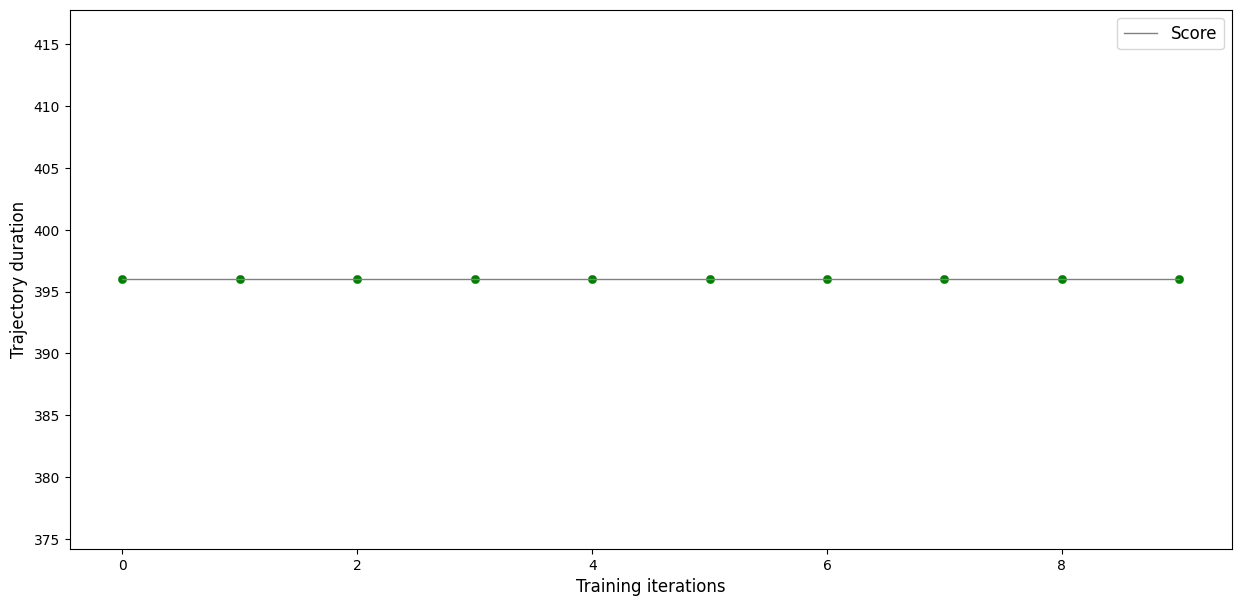

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
agent = RLAgent(env, lr = 1e-5, gamma = 0.995, max_trjectories = 100, horizon = 50000, device = device)
agent.watch_agent(model_path = 'models/rlmodel_1e-05_500_10000_2.pth', T = 1000, episodes = 10, device = 'cpu')